# Credit Card Fraud Detection - Logistic Regression Model
## October 19th, 2018
### Jose M Albornoz

# Import necessary modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import cm
style.use('fivethirtyeight')
%matplotlib inline

import seaborn as sns

import random
import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, precision_recall_curve

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

import os
import pickle
#from sklearn.externals import joblib
from flask import Flask, jsonify, request

RANDOM_STATE = 801
pd.options.mode.chained_assignment = None

# 1.- Load data

In [2]:
df_0 = data = pd.read_csv('creditcard.csv')

In [3]:
df_0.shape

(284807, 31)

In [4]:
df_0.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df_0.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

# 2.- Exploratory Data Analysis & Feature Engineering

## 2.1.- Class balance

In [6]:
np.bincount(df_0['Class'])

array([284315,    492])

In [7]:
np.bincount(df_0['Class'])*100/len(df_0)

array([99.82725144,  0.17274856])

0    284315
1       492
Name: Class, dtype: int64

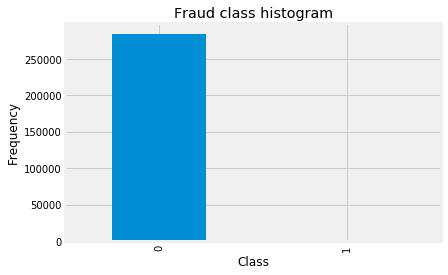

In [8]:
pd.value_counts(data['Class']).plot.bar()
plt.title('Fraud class histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
data['Class'].value_counts()

As expected in any fraud detection problem, there is a strong class imbalance in the target variable, as fraud events are rare (0.17% of the total number of transactions in this case). Therefore a strategy is required to compensate for this imbalance, which will depend on how well separated are the classes in feature space.

## 2.2 Missing values?

In [9]:
df_0.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

There are no missing values in the dataset

## 2.3.- Splitting of the original dataset in fraud & non-fraud subsets

Examining differences in the fraud/not-fraud cases will allow us to see if there are clear differentiators between the classes; for this purpose we split the dataset into fraud/no fraud subsets:

In [10]:
df_fraud0 = df_0[df_0['Class'] == 1]

In [11]:
df_not_fraud0 = df_0[df_0['Class'] == 0]

## 2.4.- Box plots for fraud & non-fraud cases

We now generate box plots for the amount and balances in the dataset for the fraud and non-fraud case; the idea is to distinguish if there are statistical evidence of fraudulent activity in the data. Only the top 5 features in order of importance are presented.

[Text(0, 0, 'Fraud'), Text(0, 0, 'Non Fraud')]

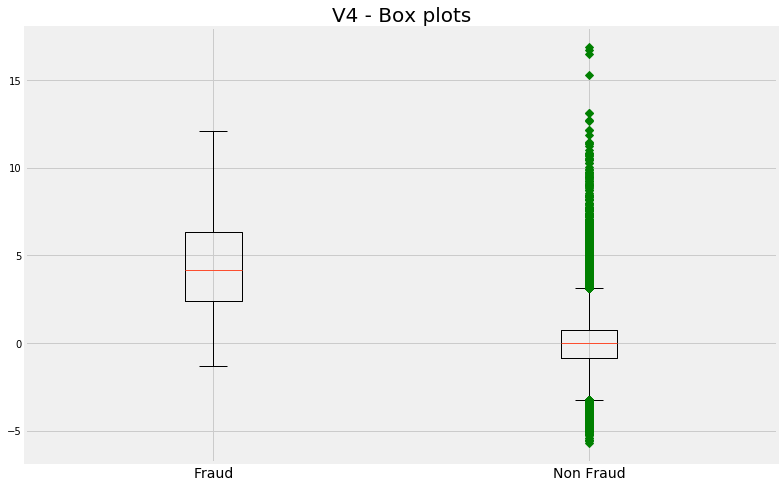

In [12]:
fig, ax = plt.subplots(figsize=(12,8))

plt.boxplot([df_fraud0['V4'], df_not_fraud0['V4']], 0, 'gD')
plt.title('V4 - Box plots', fontsize=20)

labels = ['Fraud', 'Non Fraud']
ax.set_xticklabels(labels, fontsize=14)

[Text(0, 0, 'Fraud'), Text(0, 0, 'Non Fraud')]

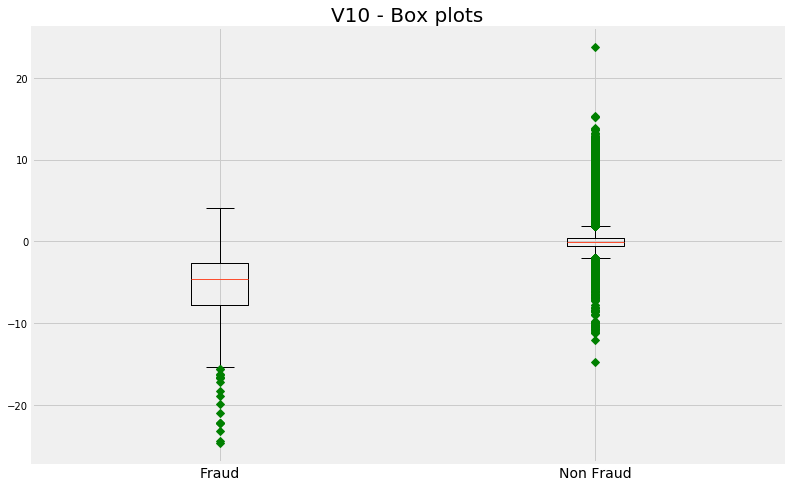

In [13]:
fig, ax = plt.subplots(figsize=(12,8))

plt.boxplot([df_fraud0['V10'], df_not_fraud0['V10']], 0, 'gD')
plt.title('V10 - Box plots', fontsize=20)

labels = ['Fraud', 'Non Fraud']
ax.set_xticklabels(labels, fontsize=14)

[Text(0, 0, 'Fraud'), Text(0, 0, 'Non Fraud')]

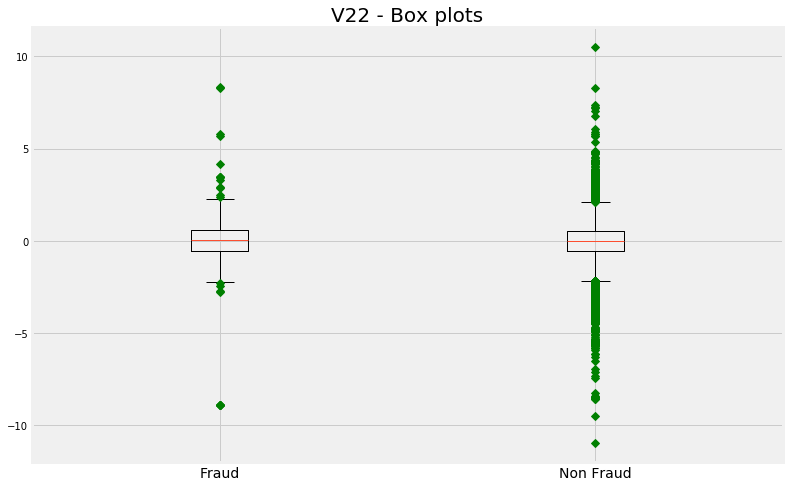

In [14]:
fig, ax = plt.subplots(figsize=(12,8))

plt.boxplot([df_fraud0['V22'], df_not_fraud0['V22']], 0, 'gD')
plt.title('V22 - Box plots', fontsize=20)

labels = ['Fraud', 'Non Fraud']
ax.set_xticklabels(labels, fontsize=14)

[Text(0, 0, 'Fraud'), Text(0, 0, 'Non Fraud')]

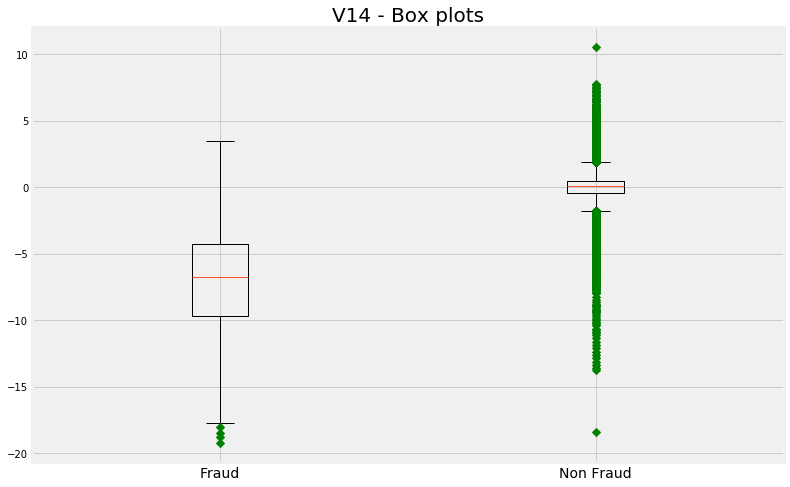

In [15]:
fig, ax = plt.subplots(figsize=(12,8))

plt.boxplot([df_fraud0['V14'], df_not_fraud0['V14']], 0, 'gD')
plt.title('V14 - Box plots', fontsize=20)

labels = ['Fraud', 'Non Fraud']
ax.set_xticklabels(labels, fontsize=14)

[Text(0, 0, 'Fraud'), Text(0, 0, 'Non Fraud')]

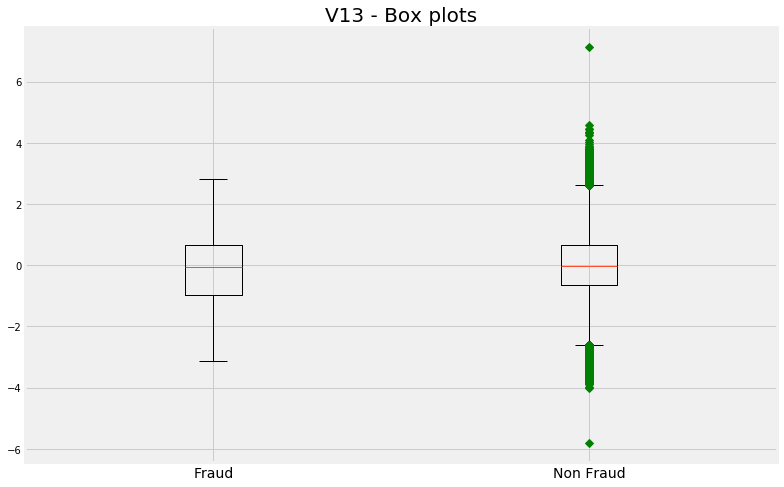

In [16]:
fig, ax = plt.subplots(figsize=(12,8))

plt.boxplot([df_fraud0['V13'], df_not_fraud0['V13']], 0, 'gD')
plt.title('V13 - Box plots', fontsize=20)

labels = ['Fraud', 'Non Fraud']
ax.set_xticklabels(labels, fontsize=14)

# 3.- Model Build

## 3.1.- Training and testing sets

### 3.1.1.- Shuffle dataset

In [17]:
df_0 = df_0.sample(frac=1, random_state=RANDOM_STATE)
df_0 = df_0.sample(frac=1, random_state=RANDOM_STATE)
df_0 = df_0.sample(frac=1, random_state=RANDOM_STATE)

### 3.1.2.- Train-test split & standardisation

In [18]:
X = df_0.drop('Class', axis=1).values

In [19]:
y = df_0['Class'].values

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)

In [21]:
stdsc = StandardScaler()
X_train = stdsc.fit_transform(X_train)
X_test = stdsc.transform(X_test)

## 3.2.- Model definition

In [22]:
parameters = {'C': np.linspace(1, 10, 10)}
lr = LogisticRegression()

## 3.3.- Grid search

In [23]:
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=-3, scoring='f1')
clf.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-3)]: Done  10 tasks      | elapsed:   12.9s
/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-3)]: Done  50 out of  50 | elapsed:   56.7s finished
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-3,
       param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=5)

In [24]:
clf.best_params_

{'C': 2.0}

In [25]:
lr1 = LogisticRegression(C=clf.best_params_['C'], penalty='l1', verbose=5)
lr1.fit(X_train, y_train.ravel())

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]

LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=5, warm_start=False)

## 3.4.- Model evaluation

As in every imbalanced classes classification problem, evaluating a model's performance in terms of accuracy can lead to erroneous results, and therefore we will be looking at other measures of model performance such as precision, recall, confusion matirx, ROC curve, AUC and precision-recall curve.

### 3.4.1.- Performance on test set - confusion matrix

In [26]:
y_pred = lr1.predict(X_test)

In [27]:
confusion = confusion_matrix(y_test, y_pred)
confusion

array([[85280,    15],
       [   55,    93]])

Text(0.5, 1.0, 'Random Forest Model')

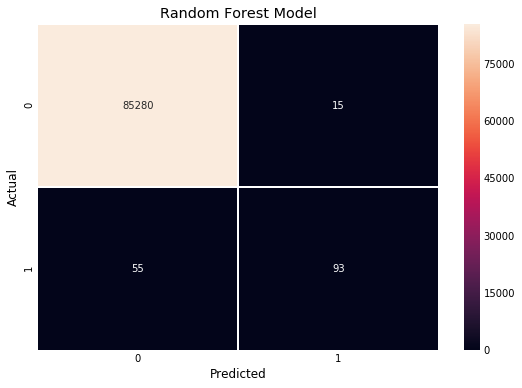

In [28]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(confusion, annot=True, fmt="d", linewidths=.5)
ax.set(xlabel='Predicted', ylabel='Actual')
ax.set_title('Random Forest Model')

### 3.4.2.- Performance on test set - recall

In [29]:
recall_score(y_test, y_pred)

0.6283783783783784

### 3.4.3.- Performance on test set - precision

In [30]:
precision_score(y_test, y_pred)

0.8611111111111112

### 3.4.4.- Performance on test set - ROC curve

In [31]:
# Compute fpr, tpr, thresholds and roc auc
probs = clf.predict_proba(X_test)
y_score = probs[:,1]
fpr, tpr, thresholds1 = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

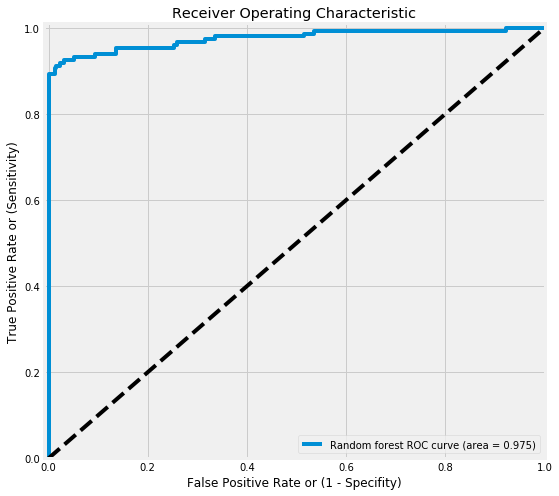

In [32]:
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label='Random forest ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

### 3.4.5.- Performance on test set - precision/recall curve

In [33]:
precision, recall, _ = precision_recall_curve(y_test, y_score)

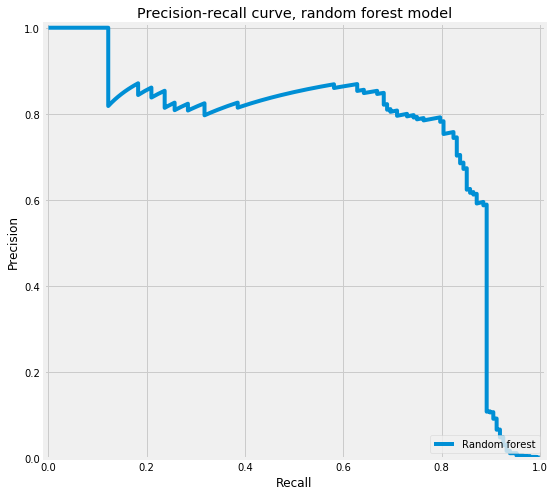

In [34]:
plt.figure(figsize=(8,8))
plt.plot(recall, precision, label='Random forest')
plt.xlim([-0.01, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve, random forest model')
plt.legend(loc="lower right")

As evidenced by the performance measures, the model does quite well in terms of detecting fraudulent activity: both precision and recall are over 99%, and ROC and precision/recall curves look good.

## 3.5.- Feature importances

In [35]:
feature_importances = np.std(X_test, 0)*lr1.coef_[0]

In [36]:
features = list(df_0.columns)
features.remove('Class')

In [37]:
df_feature_importances = pd.DataFrame({'Features':features, 'importances':abs(feature_importances)})

In [38]:
df_feature_importances.sort_values(by='importances', inplace=True, ascending=False)

In [39]:
df_feature_importances.set_index('Features', inplace=True)

Text(0, 0.5, 'Relative Importance')

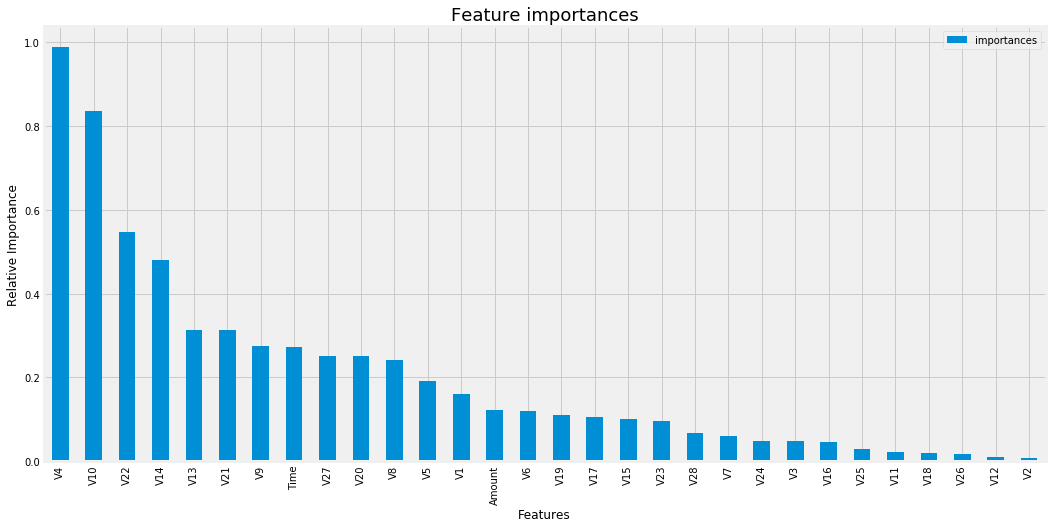

In [40]:
axes = df_feature_importances.plot.bar(figsize=(16,8))
plt.title('Feature importances', fontsize=18)
plt.ylabel('Relative Importance')